In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [15]:
import os
import cv2
import json
import random
import datetime
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
import torch

import sys 
sys.path.append('..')
from utils.utils import normalize, get_jpg_filename_list, get_png_filename_list
from utils.dataloader import *
    


In [16]:
import torch
import torch.optim as optim
import torch.nn as nn


# Varibales and data generator
input_dim_x=224
input_dim_y=224
n_filters = 32

data_filepath = '../data/azh_wound_care_center_dataset_patches/'
data_gen = DataGen(os.path.join(os.getcwd(), data_filepath), split_ratio=0.2, x=input_dim_x, y=input_dim_y)
# training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 16
epochs = 10
learning_rate = 1e-4
loss = 'binary_crossentropy'

train_loader, valid_loader, test_loader = create_dataloaders(data_gen, batch_size, device)

c:\Users\clshe\Documents\School\SUTD\Term8\Applied Deep Learning\adl_project\models\../data/azh_wound_care_center_dataset_patches/train/images/
['c:\\Users\\clshe\\Documents\\School\\SUTD\\Term8\\Applied Deep Learning\\adl_project\\models\\../data/azh_wound_care_center_dataset_patches/train/images/0020126b06a719c36fed196c2c71f2f0_0.png', 'c:\\Users\\clshe\\Documents\\School\\SUTD\\Term8\\Applied Deep Learning\\adl_project\\models\\../data/azh_wound_care_center_dataset_patches/train/images/002985bcbd572241a950bf39b4188d70_0.png', 'c:\\Users\\clshe\\Documents\\School\\SUTD\\Term8\\Applied Deep Learning\\adl_project\\models\\../data/azh_wound_care_center_dataset_patches/train/images/00437234527092743faeb39bc59bd7ee_0.png', 'c:\\Users\\clshe\\Documents\\School\\SUTD\\Term8\\Applied Deep Learning\\adl_project\\models\\../data/azh_wound_care_center_dataset_patches/train/images/00be2ad4736f6657b767683186615f3f_0.png', 'c:\\Users\\clshe\\Documents\\School\\SUTD\\Term8\\Applied Deep Learning\\a

In [21]:
n_channels = 3  # For RGB images
n_classes = 1   # For binary classification/segmentation

# Optionally, define the number of filters in the first layer
n_filters =  64 # Default value, but you can customize it

# Create an instance of the UNetYuanqing model
unet_model = UNet(n_channels, n_classes)
unet_model = UNet2(n_channels, n_classes, n_filters)
# If you're planning to use a GPU, don't forget to move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = unet_model.to(device)
print(unet_model.modules)

<bound method Module.modules of UNet2(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
  )
  (down2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        

In [22]:
def predict(model, inputs, device):
    model = model.to(device)
    outputs = model(inputs)
    predicted = torch.argmax(outputs, 1)
    return outputs, predicted


# early_stopping = EarlyStopping(patience=200, verbose=True, path='path_to_save_checkpoint.pth')


def dice_coeff(pred, target, smooth=1):
    pred_flat = pred.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)


def train(model, train_loader, valid_loader, epochs = 10, lr = 0.001,checkpoint_path='model_checkpoint.pth'):
# Use Adam optimizer to update model weights
    optimizer = optim.Adam(unet_model.parameters(), lr = lr)
    # Use cross-entropy loss function
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCELoss()
    best_valid_loss = float('inf')


    for epoch in range(epochs):
        # Set model to training mode
        model.train()
        # Initialize epoch loss and accuracy
        train_loss = 0.0
        train_dice = 0.0
        # Iterate over training data
        for batch_number, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            # print(inputs.size)
            # print(outputs.size)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            dice_score = dice_coeff(outputs, labels)
            train_dice += dice_score.item() * inputs.size(0)

            print(f'Batch {batch_number+1}/{len(train_loader)} Train loss: {train_loss:.4f} ',
              f'Train Dice: {train_dice:.4f}')

# Validation phase
        model.eval()
        valid_loss = 0.0
        valid_dice = 0.0
        # Iterate over test data

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item() * inputs.size(0)
                dice_score = dice_coeff(outputs, labels)
                valid_dice += dice_score.item() * inputs.size(0)
             # Calculate average losses

        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(valid_loader.dataset)
        # Calculate average dice coefficient
        train_dice = train_dice / len(train_loader.dataset)
        valid_dice = valid_dice / len(valid_loader.dataset)
        
        print(f'Epoch {epoch+1}/{epochs} Train loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, '
              f'Train Dice: {train_dice:.4f}, Valid Dice: {valid_dice:.4f}')
        
        # Save model checkpoint if validation loss has improved
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Model checkpoint saved at epoch {epoch+1} with validation loss: {valid_loss:.4f}')
        

train(unet_model, train_loader,  test_loader,  epochs = epochs, lr = learning_rate)

<built-in method size of Tensor object at 0x00000213D8C476D0>
<built-in method size of Tensor object at 0x00000213A5F10630>
Batch 1/16 Train loss: 10.4014  Train Dice: 1.0635
<built-in method size of Tensor object at 0x00000213D8C476D0>
<built-in method size of Tensor object at 0x00000213A5F0A090>
Batch 2/16 Train loss: 20.7786  Train Dice: 2.2117
<built-in method size of Tensor object at 0x00000213D8C476D0>
<built-in method size of Tensor object at 0x00000213A5F0A0E0>
Batch 3/16 Train loss: 31.1120  Train Dice: 3.1064
<built-in method size of Tensor object at 0x00000213D8C476D0>
<built-in method size of Tensor object at 0x00000213A6A0D4F0>
Batch 4/16 Train loss: 41.4343  Train Dice: 4.3192
<built-in method size of Tensor object at 0x00000213D8C476D0>
<built-in method size of Tensor object at 0x00000213A5F0A900>
Batch 5/16 Train loss: 51.6931  Train Dice: 5.0559
<built-in method size of Tensor object at 0x00000213D8C476D0>
<built-in method size of Tensor object at 0x00000213A5F06D60>
B

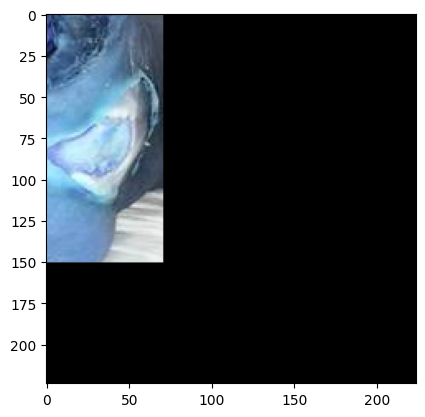

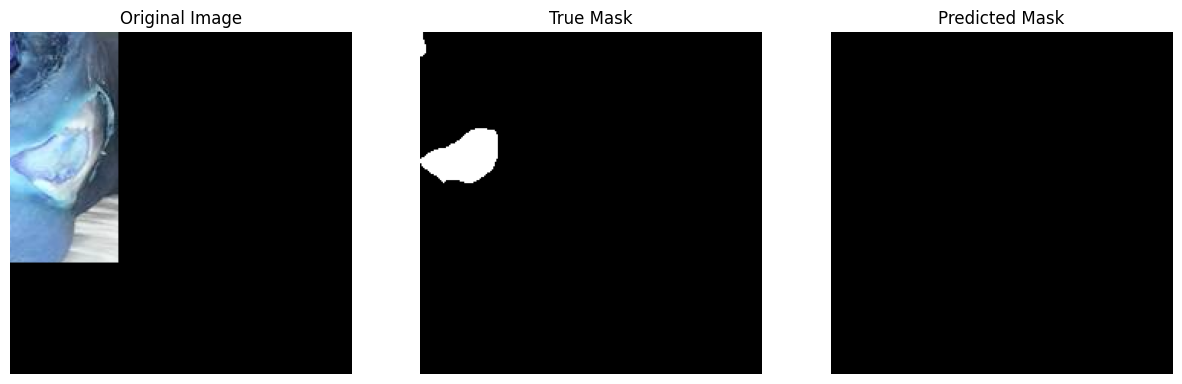

In [46]:
# Assuming test_loader is defined and device is set
for inputs, labels in test_loader:
    # Randomly select one image and label from the batch
    idx = torch.randint(0, inputs.size(0), (1,)).item()
    image = inputs[idx]
    # show image
    plt.imshow(image.permute(1, 2, 0).cpu())
    label = labels[idx]
    break  # Only iterate over one batch


image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

unet_model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():  # Disable gradient calculation
    output = unet_model(image)
    predicted_mask = (output > 0.5).float()  # Threshold probabilities to get a binary mask
    predicted_mask = predicted_mask.squeeze(0)  # Remove batch dimension for visualization

# Move the image and predicted mask back to CPU for visualization
image = image.squeeze(0).cpu()
predicted_mask = predicted_mask.cpu()


# Visualization
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image.permute(1, 2, 0).cpu())
plt.title('Original Image')
plt.axis('off')

# True mask
plt.subplot(1, 3, 2)
plt.imshow(label.squeeze().numpy(), cmap='gray')
plt.title('True Mask')
plt.axis('off')

# Predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.squeeze().numpy(), cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.show()
